# loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Reshape, Layer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import activations, backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, History

# Define the path to your dataset
dataset_path = r"C:\Users\user\OneDrive\Documents\nitw\spectogram Work\Spectograms"

# Create an instance of the ImageDataGenerator to load images
datagen = ImageDataGenerator(
    rescale=1./255  # Scale the images by dividing each pixel by 255
)

# Initialize the generator
generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(200, 200),
    color_mode='rgb',  # Load images in RGB
    class_mode='categorical',  # Labels are returned in categorical format
    batch_size=32,  # You can adjust the batch size according to your need
    shuffle=False  # Set to False to maintain consistent order across epochs (useful for this collection process)
)

# Prepare to collect all images and labels
all_images = []
all_labels = []

# Iterate over all batches and collect images and labels
for _ in range(generator.samples // generator.batch_size + 1):  # Ensure you capture all batches
    imgs, lbls = next(generator)
    all_images.append(imgs)
    all_labels.append(lbls)

# Concatenate all batches into single arrays
all_images = np.concatenate(all_images, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Verify the shapes of the full datasets
print("All images shape:", all_images.shape)
print("All labels shape:", all_labels.shape)


X_train, X_test, Y_train, Y_test = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)
X_train.shape, Y_train.shape


# Create dataset and dataloader
train_datagen = ImageDataGenerator()
train_generator = train_datagen.flow(X_train, Y_train, batch_size=32)

test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow(X_test, Y_test, batch_size=32)

# Ensure that the generators produce enough batches
steps_per_epoch = len(train_generator)
validation_steps = len(test_generator)


Found 4200 images belonging to 3 classes.


# model using Adam

GPU is available and configured.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 200, 200, 32)         896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 200, 200, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 100, 100, 32)         0  

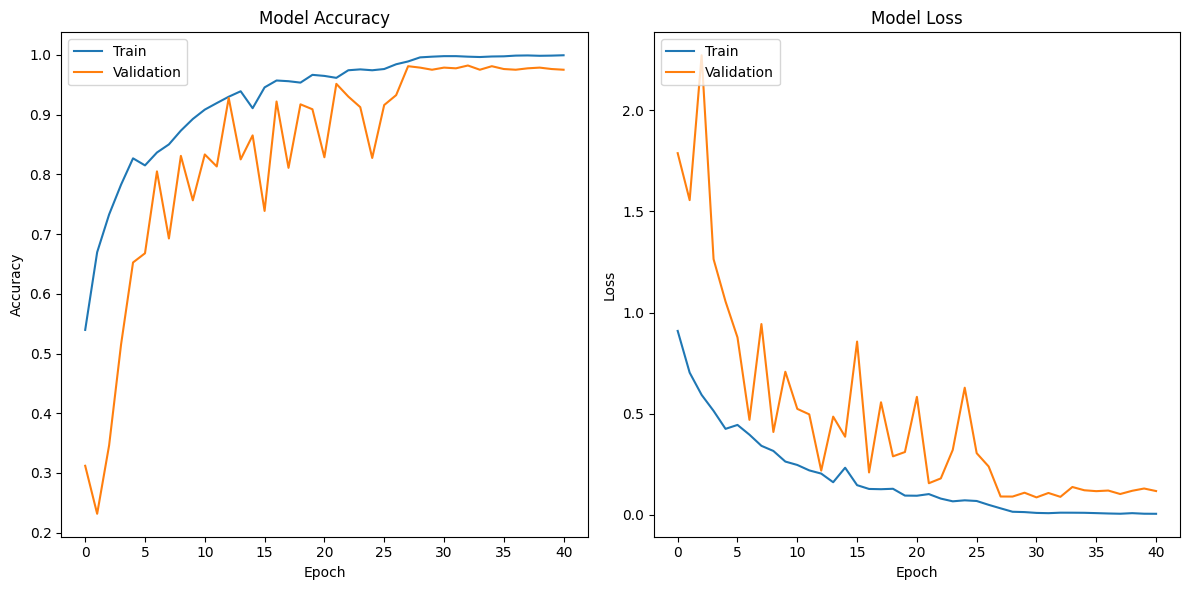

27/27 - 2s - loss: 0.0850 - accuracy: 0.9787 - f1_score: 0.9787 - 2s/epoch - 61ms/step
Test Accuracy: 0.978723406791687
Test F1 Score: 0.9787233471870422


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.metrics import Metric
from tensorflow.keras.callbacks import EarlyStopping, History, ReduceLROnPlateau
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

# Set up GPU configuration
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth to avoid memory allocation issues
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is available and configured.")
    except RuntimeError as e:
        print(e)
else:
    print("GPU not available. Using CPU.")

# Custom F1 Score Metric
class F1Score(Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(tf.math.round(y_pred), tf.float32)
        self.true_positives.assign_add(tf.reduce_sum(y_true * y_pred))
        self.false_positives.assign_add(tf.reduce_sum((1 - y_true) * y_pred))
        self.false_negatives.assign_add(tf.reduce_sum(y_true * (1 - y_pred)))

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + K.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + K.epsilon())
        f1 = 2 * precision * recall / (precision + recall + K.epsilon())
        return f1

# Squash Activation Function
def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    scale = K.sqrt(s_squared_norm) / (0.5 + s_squared_norm)
    return scale * x

# Softmax Function
def softmax(x, axis=-1):
    ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
    return ex / K.sum(ex, axis=axis, keepdims=True)

# Capsule Layer
class Capsule(Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3, share_weights=True, activation='squash', **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights
        if activation == 'squash':
            self.activation = squash
        else:
            self.activation = layers.Activation(activation)

    def build(self, input_shape):
        super(Capsule, self).build(input_shape)
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(1, input_dim_capsule, self.num_capsule * self.dim_capsule),
                                     initializer='glorot_uniform',
                                     trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(input_num_capsule, input_dim_capsule, self.num_capsule * self.dim_capsule),
                                     initializer='glorot_uniform',
                                     trainable=True)

    def call(self, u_vecs):
        if self.share_weights:
            u_hat_vecs = K.conv1d(u_vecs, self.W)
        else:
            u_hat_vecs = K.local_conv1d(u_vecs, self.W, [1], [1])

        batch_size = K.shape(u_vecs)[0]
        input_num_capsule = K.shape(u_vecs)[1]
        u_hat_vecs = K.reshape(u_hat_vecs, (batch_size, input_num_capsule, self.num_capsule, self.dim_capsule))
        u_hat_vecs = K.permute_dimensions(u_hat_vecs, (0, 2, 1, 3))
        b = K.zeros_like(u_hat_vecs[:,:,:,0])
        for i in range(self.routings):
            c = softmax(b, 1)
            o = tf.einsum('bin,binj->bij', c, u_hat_vecs)
            if K.backend() == 'theano':
                o = K.sum(o, axis=1)
            if i < self.routings - 1:
                o = K.l2_normalize(o, -1)
                b = tf.einsum('bij,binj->bin', o, u_hat_vecs)
                if K.backend() == 'theano':
                    b = K.sum(b, axis=1)
        return self.activation(o)

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)

# Attention Mechanism
def attention_block(inputs, filters):
    attention = layers.Conv2D(filters, (1, 1), activation='relu', padding='same')(inputs)
    attention = layers.Conv2D(filters, (1, 1), activation='sigmoid', padding='same')(attention)
    return layers.multiply([inputs, attention])

# Residual Block
def residual_block(inputs, filters):
    x = layers.Conv2D(filters, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.add([x, inputs])
    x = layers.ReLU()(x)
    return x

# Define the model architecture
def get_model(inputShape):
    input_image = Input(shape=inputShape)

    # Initial Convolutional Layer
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_image)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    # Residual Blocks with Attention
    for _ in range(2):
        x = residual_block(x, 32)
        x = attention_block(x, 32)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    for _ in range(2):
        x = residual_block(x, 64)
        x = attention_block(x, 64)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    for _ in range(2):
        x = residual_block(x, 128)
        x = attention_block(x, 128)

    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    for _ in range(2):
        x = residual_block(x, 256)
        x = attention_block(x, 256)

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Capsule Layer
    x = layers.Reshape((-1, 256))(x)
    capsule = Capsule(num_capsule=10, dim_capsule=16, routings=3, share_weights=True)(x)
    capsule = layers.Flatten()(capsule)
    capsule = layers.Dense(128, activation='relu')(capsule)
    capsule = layers.Dropout(0.5)(capsule)

    # Output Layer
    output = layers.Dense(3, activation='softmax')(capsule)

    # Create and compile the model
    model = models.Model(inputs=input_image, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', F1Score()])
    model.summary()

    return model

# Instantiate the model
model = get_model((200, 200, 3))

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# History callback
history = History()

# Train the model
epochs = 80
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=test_generator,
    validation_steps=len(test_generator),
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr]
)

# Plot training & validation accuracy and loss values in a single graph
plt.figure(figsize=(12, 6))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Show the plots
plt.tight_layout()
plt.show()

# Evaluate the model
test_loss, test_acc, test_f1_score = model.evaluate(test_generator, verbose=2)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", test_f1_score)


# Using Rectified adam

In [ ]:
pip install tensorflow-addons


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.9 MB/s eta 0:00:00


GPU is available and configured.
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 conv2d_216 (Conv2D)         (None, 200, 200, 32)         896       ['input_7[0][0]']             
                                                                                                  
 batch_normalization_120 (B  (None, 200, 200, 32)         128       ['conv2d_216[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 max_pooling2d_24 (MaxPooli  (None, 100, 100, 32)         0

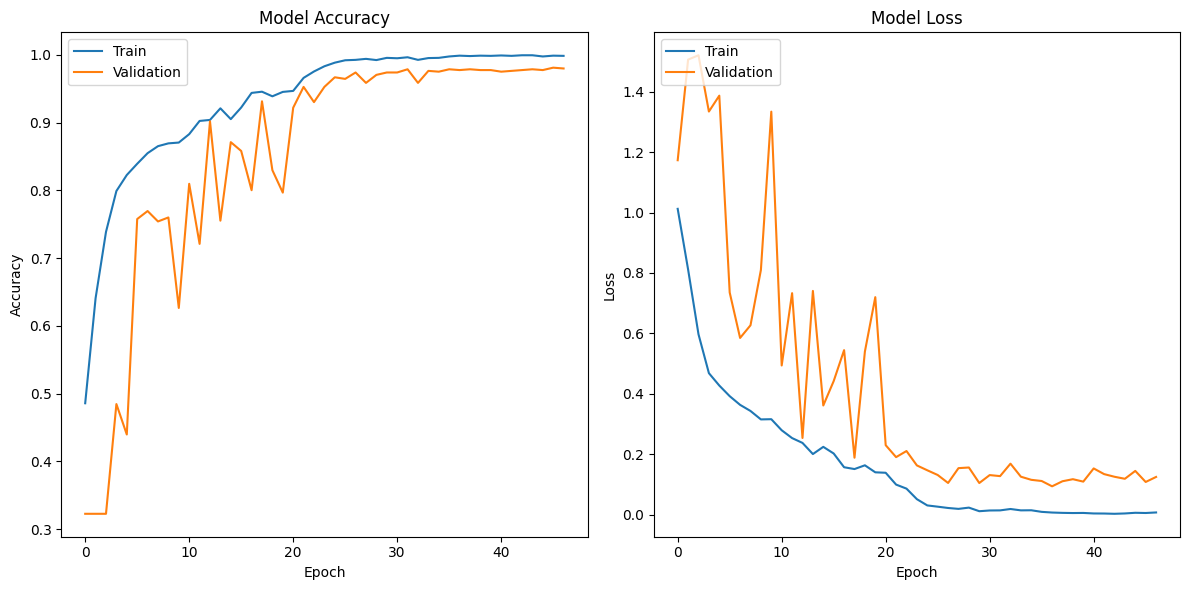

27/27 - 2s - loss: 0.0941 - accuracy: 0.9775 - f1_score: 0.9775 - 2s/epoch - 59ms/step
Test Accuracy: 0.9775413870811462
Test F1 Score: 0.9775413274765015


In [ ]:
import tensorflow_addons as tfa

# Set up GPU configuration
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth to avoid memory allocation issues
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is available and configured.")
    except RuntimeError as e:
        print(e)
else:
    print("GPU not available. Using CPU.")

# Custom F1 Score Metric
class F1Score(Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(tf.math.round(y_pred), tf.float32)
        self.true_positives.assign_add(tf.reduce_sum(y_true * y_pred))
        self.false_positives.assign_add(tf.reduce_sum((1 - y_true) * y_pred))
        self.false_negatives.assign_add(tf.reduce_sum(y_true * (1 - y_pred)))

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + K.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + K.epsilon())
        f1 = 2 * precision * recall / (precision + recall + K.epsilon())
        return f1

# Squash Activation Function
def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    scale = K.sqrt(s_squared_norm) / (0.5 + s_squared_norm)
    return scale * x

# Softmax Function
def softmax(x, axis=-1):
    ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
    return ex / K.sum(ex, axis=axis, keepdims=True)

# Capsule Layer
class Capsule(Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3, share_weights=True, activation='squash', **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights
        if activation == 'squash':
            self.activation = squash
        else:
            self.activation = layers.Activation(activation)

    def build(self, input_shape):
        super(Capsule, self).build(input_shape)
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(1, input_dim_capsule, self.num_capsule * self.dim_capsule),
                                     initializer='glorot_uniform',
                                     trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(input_num_capsule, input_dim_capsule, self.num_capsule * self.dim_capsule),
                                     initializer='glorot_uniform',
                                     trainable=True)

    def call(self, u_vecs):
        if self.share_weights:
            u_hat_vecs = K.conv1d(u_vecs, self.W)
        else:
            u_hat_vecs = K.local_conv1d(u_vecs, self.W, [1], [1])

        batch_size = K.shape(u_vecs)[0]
        input_num_capsule = K.shape(u_vecs)[1]
        u_hat_vecs = K.reshape(u_hat_vecs, (batch_size, input_num_capsule, self.num_capsule, self.dim_capsule))
        u_hat_vecs = K.permute_dimensions(u_hat_vecs, (0, 2, 1, 3))
        b = K.zeros_like(u_hat_vecs[:,:,:,0])
        for i in range(self.routings):
            c = softmax(b, 1)
            o = tf.einsum('bin,binj->bij', c, u_hat_vecs)
            if K.backend() == 'theano':
                o = K.sum(o, axis=1)
            if i < self.routings - 1:
                o = K.l2_normalize(o, -1)
                b = tf.einsum('bij,binj->bin', o, u_hat_vecs)
                if K.backend() == 'theano':
                    b = K.sum(b, axis=1)
        return self.activation(o)

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)

# Attention Mechanism
def attention_block(inputs, filters):
    attention = layers.Conv2D(filters, (1, 1), activation='relu', padding='same')(inputs)
    attention = layers.Conv2D(filters, (1, 1), activation='sigmoid', padding='same')(attention)
    return layers.multiply([inputs, attention])

# Residual Block
def residual_block(inputs, filters):
    x = layers.Conv2D(filters, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.add([x, inputs])
    x = layers.ReLU()(x)
    return x

# Define the model architecture
def get_model(inputShape):
    input_image = Input(shape=inputShape)

    # Initial Convolutional Layer
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_image)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    # Residual Blocks with Attention
    for _ in range(2):
        x = residual_block(x, 32)
        x = attention_block(x, 32)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    for _ in range(2):
        x = residual_block(x, 64)
        x = attention_block(x, 64)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    for _ in range(2):
        x = residual_block(x, 128)
        x = attention_block(x, 128)

    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    for _ in range(2):
        x = residual_block(x, 256)
        x = attention_block(x, 256)

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Capsule Layer
    x = layers.Reshape((-1, 256))(x)
    capsule = Capsule(num_capsule=10, dim_capsule=16, routings=3, share_weights=True)(x)
    capsule = layers.Flatten()(capsule)
    capsule = layers.Dense(128, activation='relu')(capsule)
    capsule = layers.Dropout(0.5)(capsule)

    # Output Layer
    output = layers.Dense(3, activation='softmax')(capsule)

    # Create and compile the model
    model = models.Model(inputs=input_image, outputs=output)

    # Use Rectified Adam optimizer
    radam = tfa.optimizers.RectifiedAdam(learning_rate=1e-3)
    model.compile(loss='categorical_crossentropy', optimizer=radam, metrics=['accuracy', F1Score()])

    model.summary()

    return model

# Instantiate the model
model = get_model((200, 200, 3))

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# History callback
history = History()

# Train the model
epochs = 50
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=test_generator,
    validation_steps=len(test_generator),
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr]
)

# Plot training & validation accuracy and loss values in a single graph
plt.figure(figsize=(12, 6))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Show the plots
plt.tight_layout()
plt.show()

# Evaluate the model
test_loss, test_acc, test_f1_score = model.evaluate(test_generator, verbose=2)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", test_f1_score)


# using adagrad optimizer

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.metrics import Metric
from tensorflow.keras.callbacks import EarlyStopping, History, ReduceLROnPlateau
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

# Set up GPU configuration
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth to avoid memory allocation issues
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is available and configured.")
    except RuntimeError as e:
        print(e)
else:
    print("GPU not available. Using CPU.")

# Custom F1 Score Metric
class F1Score(Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(tf.math.round(y_pred), tf.float32)
        self.true_positives.assign_add(tf.reduce_sum(y_true * y_pred))
        self.false_positives.assign_add(tf.reduce_sum((1 - y_true) * y_pred))
        self.false_negatives.assign_add(tf.reduce_sum(y_true * (1 - y_pred)))

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + K.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + K.epsilon())
        f1 = 2 * precision * recall / (precision + recall + K.epsilon())
        return f1

# Squash Activation Function
def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    scale = K.sqrt(s_squared_norm) / (0.5 + s_squared_norm)
    return scale * x

# Softmax Function
def softmax(x, axis=-1):
    ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
    return ex / K.sum(ex, axis=axis, keepdims=True)

# Capsule Layer
class Capsule(Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3, share_weights=True, activation='squash', **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights
        if activation == 'squash':
            self.activation = squash
        else:
            self.activation = layers.Activation(activation)

    def build(self, input_shape):
        super(Capsule, self).build(input_shape)
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(1, input_dim_capsule, self.num_capsule * self.dim_capsule),
                                     initializer='glorot_uniform',
                                     trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(input_num_capsule, input_dim_capsule, self.num_capsule * self.dim_capsule),
                                     initializer='glorot_uniform',
                                     trainable=True)

    def call(self, u_vecs):
        if self.share_weights:
            u_hat_vecs = K.conv1d(u_vecs, self.W)
        else:
            u_hat_vecs = K.local_conv1d(u_vecs, self.W, [1], [1])

        batch_size = K.shape(u_vecs)[0]
        input_num_capsule = K.shape(u_vecs)[1]
        u_hat_vecs = K.reshape(u_hat_vecs, (batch_size, input_num_capsule, self.num_capsule, self.dim_capsule))
        u_hat_vecs = K.permute_dimensions(u_hat_vecs, (0, 2, 1, 3))
        b = K.zeros_like(u_hat_vecs[:,:,:,0])
        for i in range(self.routings):
            c = softmax(b, 1)
            o = tf.einsum('bin,binj->bij', c, u_hat_vecs)
            if K.backend() == 'theano':
                o = K.sum(o, axis=1)
            if i < self.routings - 1:
                o = K.l2_normalize(o, -1)
                b = tf.einsum('bij,binj->bin', o, u_hat_vecs)
                if K.backend() == 'theano':
                    b = K.sum(b, axis=1)
        return self.activation(o)

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)

# Attention Mechanism
def attention_block(inputs, filters):
    attention = layers.Conv2D(filters, (1, 1), activation='relu', padding='same')(inputs)
    attention = layers.Conv2D(filters, (1, 1), activation='sigmoid', padding='same')(attention)
    return layers.multiply([inputs, attention])

# Residual Block
def residual_block(inputs, filters):
    x = layers.Conv2D(filters, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.add([x, inputs])
    x = layers.ReLU()(x)
    return x

# Define the model architecture
def get_model(inputShape):
    input_image = Input(shape=inputShape)

    # Initial Convolutional Layer
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_image)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    # Residual Blocks with Attention
    for _ in range(2):
        x = residual_block(x, 32)
        x = attention_block(x, 32)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    for _ in range(2):
        x = residual_block(x, 64)
        x = attention_block(x, 64)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    for _ in range(2):
        x = residual_block(x, 128)
        x = attention_block(x, 128)

    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    for _ in range(2):
        x = residual_block(x, 256)
        x = attention_block(x, 256)

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Capsule Layer
    x = layers.Reshape((-1, 256))(x)
    capsule = Capsule(num_capsule=10, dim_capsule=16, routings=3, share_weights=True)(x)
    capsule = layers.Flatten()(capsule)
    capsule = layers.Dense(128, activation='relu')(capsule)
    capsule = layers.Dropout(0.5)(capsule)

    # Output Layer
    output = layers.Dense(3, activation='softmax')(capsule)

    # Create and compile the model
    model = models.Model(inputs=input_image, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=['accuracy', F1Score()])
    model.summary()

    return model

# Instantiate the model
model = get_model((200, 200, 3))

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# History callback
history = History()

# Train the model
epochs = 80
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=test_generator,
    validation_steps=len(test_generator),
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr]
)

# Plot training & validation accuracy and loss values in a single graph
plt.figure(figsize=(12, 6))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Show the plots
plt.tight_layout()
plt.show()

# Evaluate the model
test_loss, test_acc, test_f1_score = model.evaluate(test_generator, verbose=2)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", test_f1_score)


Physical devices cannot be modified after being initialized
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 conv2d_109 (Conv2D)         (None, 200, 200, 32)         896       ['input_8[0][0]']             
                                                                                                  
 batch_normalization_61 (Ba  (None, 200, 200, 32)         128       ['conv2d_109[0][0]']          
 tchNormalization)                                                                                
                                                                                                  
 max_pooling2d_13 (MaxPooli  (No

KeyboardInterrupt: 

# using AdamW (Adam with Weight Decay)

Physical devices cannot be modified after being initialized
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 conv2d_181 (Conv2D)         (None, 200, 200, 32)         896       ['input_10[0][0]']            
                                                                                                  
 batch_normalization_101 (B  (None, 200, 200, 32)         128       ['conv2d_181[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 max_pooling2d_21 (MaxPooli  (No

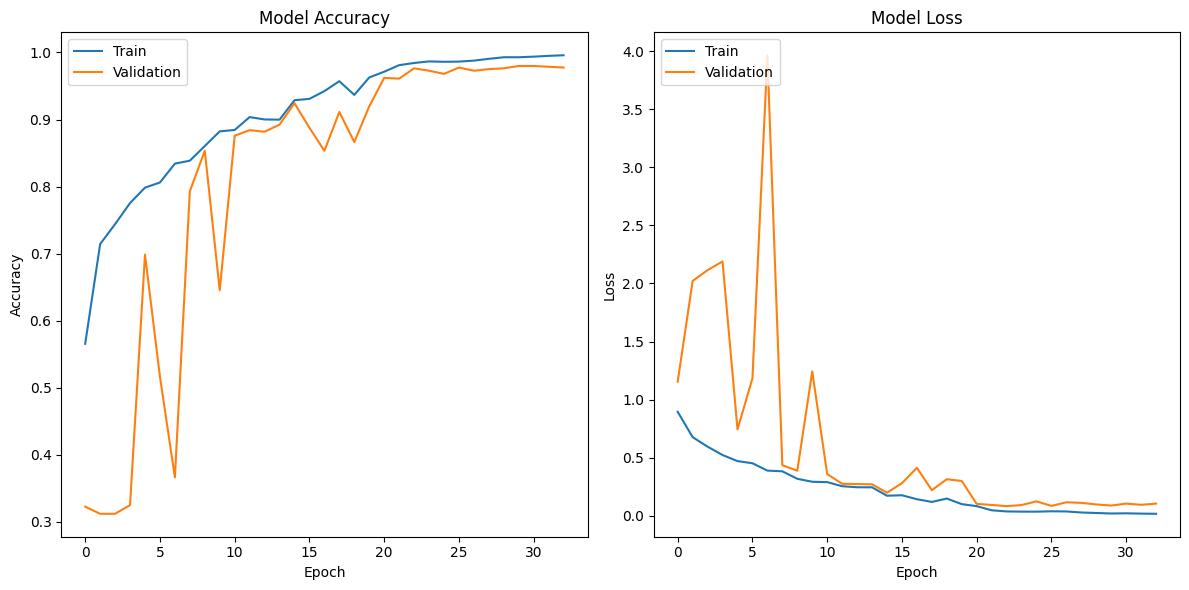

27/27 - 2s - loss: 0.0830 - accuracy: 0.9764 - f1_score: 0.9758 - 2s/epoch - 60ms/step
Test Accuracy: 0.9763593673706055
Test F1 Score: 0.975753903388977


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.metrics import Metric
from tensorflow.keras.callbacks import EarlyStopping, History, ReduceLROnPlateau
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import AdamW

# Set up GPU configuration
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth to avoid memory allocation issues
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is available and configured.")
    except RuntimeError as e:
        print(e)
else:
    print("GPU not available. Using CPU.")

# Custom F1 Score Metric
class F1Score(Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(tf.math.round(y_pred), tf.float32)
        self.true_positives.assign_add(tf.reduce_sum(y_true * y_pred))
        self.false_positives.assign_add(tf.reduce_sum((1 - y_true) * y_pred))
        self.false_negatives.assign_add(tf.reduce_sum(y_true * (1 - y_pred)))

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + K.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + K.epsilon())
        f1 = 2 * precision * recall / (precision + recall + K.epsilon())
        return f1

# Squash Activation Function
def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    scale = K.sqrt(s_squared_norm) / (0.5 + s_squared_norm)
    return scale * x

# Softmax Function
def softmax(x, axis=-1):
    ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
    return ex / K.sum(ex, axis=axis, keepdims=True)

# Capsule Layer
class Capsule(Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3, share_weights=True, activation='squash', **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights
        if activation == 'squash':
            self.activation = squash
        else:
            self.activation = layers.Activation(activation)

    def build(self, input_shape):
        super(Capsule, self).build(input_shape)
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(1, input_dim_capsule, self.num_capsule * self.dim_capsule),
                                     initializer='glorot_uniform',
                                     trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(input_num_capsule, input_dim_capsule, self.num_capsule * self.dim_capsule),
                                     initializer='glorot_uniform',
                                     trainable=True)

    def call(self, u_vecs):
        if self.share_weights:
            u_hat_vecs = K.conv1d(u_vecs, self.W)
        else:
            u_hat_vecs = K.local_conv1d(u_vecs, self.W, [1], [1])

        batch_size = K.shape(u_vecs)[0]
        input_num_capsule = K.shape(u_vecs)[1]
        u_hat_vecs = K.reshape(u_hat_vecs, (batch_size, input_num_capsule, self.num_capsule, self.dim_capsule))
        u_hat_vecs = K.permute_dimensions(u_hat_vecs, (0, 2, 1, 3))
        b = K.zeros_like(u_hat_vecs[:,:,:,0])
        for i in range(self.routings):
            c = softmax(b, 1)
            o = tf.einsum('bin,binj->bij', c, u_hat_vecs)
            if K.backend() == 'theano':
                o = K.sum(o, axis=1)
            if i < self.routings - 1:
                o = K.l2_normalize(o, -1)
                b = tf.einsum('bij,binj->bin', o, u_hat_vecs)
                if K.backend() == 'theano':
                    b = K.sum(b, axis=1)
        return self.activation(o)

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)

# Attention Mechanism
def attention_block(inputs, filters):
    attention = layers.Conv2D(filters, (1, 1), activation='relu', padding='same')(inputs)
    attention = layers.Conv2D(filters, (1, 1), activation='sigmoid', padding='same')(attention)
    return layers.multiply([inputs, attention])

# Residual Block
def residual_block(inputs, filters):
    x = layers.Conv2D(filters, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.add([x, inputs])
    x = layers.ReLU()(x)
    return x

# Define the model architecture
def get_model(inputShape):
    input_image = Input(shape=inputShape)

    # Initial Convolutional Layer
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_image)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    # Residual Blocks with Attention
    for _ in range(2):
        x = residual_block(x, 32)
        x = attention_block(x, 32)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    for _ in range(2):
        x = residual_block(x, 64)
        x = attention_block(x, 64)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    for _ in range(2):
        x = residual_block(x, 128)
        x = attention_block(x, 128)

    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    for _ in range(2):
        x = residual_block(x, 256)
        x = attention_block(x, 256)

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Capsule Layer
    x = layers.Reshape((-1, 256))(x)
    capsule = Capsule(num_capsule=10, dim_capsule=16, routings=3, share_weights=True)(x)
    capsule = layers.Flatten()(capsule)
    capsule = layers.Dense(128, activation='relu')(capsule)
    capsule = layers.Dropout(0.5)(capsule)

    # Output Layer
    output = layers.Dense(3, activation='softmax')(capsule)

    # Create and compile the model
    model = models.Model(inputs=input_image, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer=AdamW(), metrics=['accuracy', F1Score()])
    model.summary()

    return model

# Instantiate the model
model = get_model((200, 200, 3))

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# History callback
history = History()

# Train the model
epochs = 80
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=test_generator,
    validation_steps=len(test_generator),
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr]
)

# Plot training & validation accuracy and loss values in a single graph
plt.figure(figsize=(12, 6))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Show the plots
plt.tight_layout()
plt.show()

# Evaluate the model
test_loss, test_acc, test_f1_score = model.evaluate(test_generator, verbose=2)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", test_f1_score)



#  using Nadam (Nesterov-accelerated Adaptive Moment Estimation)

Physical devices cannot be modified after being initialized
Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 conv2d_217 (Conv2D)         (None, 200, 200, 32)         896       ['input_11[0][0]']            
                                                                                                  
 batch_normalization_121 (B  (None, 200, 200, 32)         128       ['conv2d_217[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 max_pooling2d_25 (MaxPooli  (No

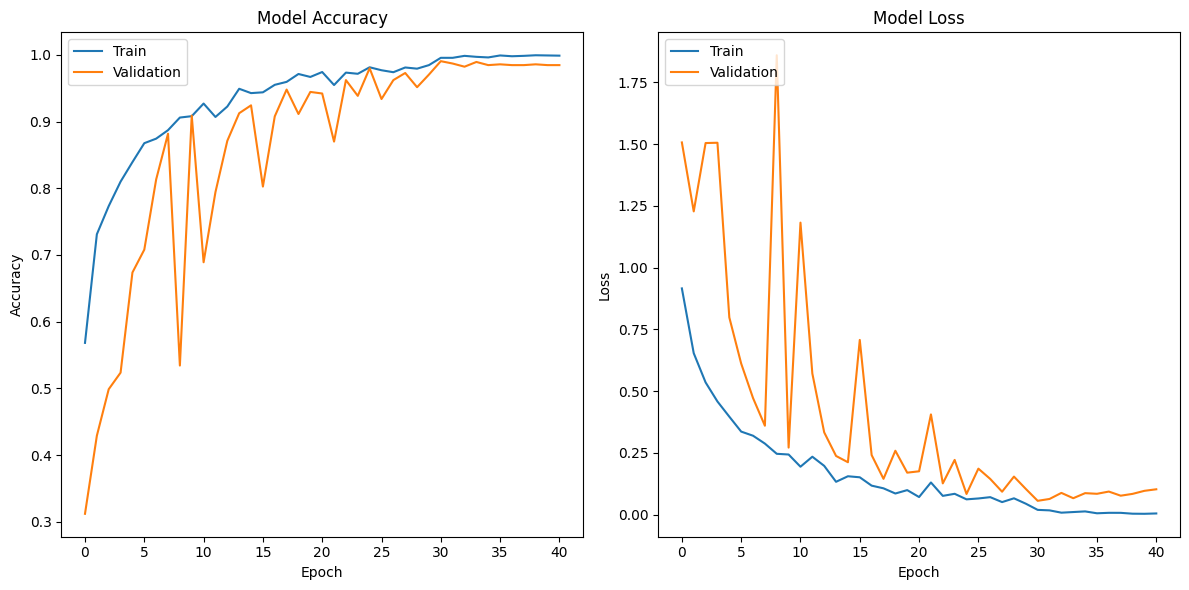

27/27 - 2s - loss: 0.0559 - accuracy: 0.9905 - f1_score: 0.9905 - 2s/epoch - 58ms/step
Test Accuracy: 0.9905437231063843
Test F1 Score: 0.9905436635017395


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.metrics import Metric
from tensorflow.keras.callbacks import EarlyStopping, History, ReduceLROnPlateau
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Nadam

# Set up GPU configuration
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth to avoid memory allocation issues
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is available and configured.")
    except RuntimeError as e:
        print(e)
else:
    print("GPU not available. Using CPU.")

# Custom F1 Score Metric
class F1Score(Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(tf.math.round(y_pred), tf.float32)
        self.true_positives.assign_add(tf.reduce_sum(y_true * y_pred))
        self.false_positives.assign_add(tf.reduce_sum((1 - y_true) * y_pred))
        self.false_negatives.assign_add(tf.reduce_sum(y_true * (1 - y_pred)))

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + K.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + K.epsilon())
        f1 = 2 * precision * recall / (precision + recall + K.epsilon())
        return f1

# Squash Activation Function
def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    scale = K.sqrt(s_squared_norm) / (0.5 + s_squared_norm)
    return scale * x

# Softmax Function
def softmax(x, axis=-1):
    ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
    return ex / K.sum(ex, axis=axis, keepdims=True)

# Capsule Layer
class Capsule(Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3, share_weights=True, activation='squash', **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights
        if activation == 'squash':
            self.activation = squash
        else:
            self.activation = layers.Activation(activation)

    def build(self, input_shape):
        super(Capsule, self).build(input_shape)
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(1, input_dim_capsule, self.num_capsule * self.dim_capsule),
                                     initializer='glorot_uniform',
                                     trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(input_num_capsule, input_dim_capsule, self.num_capsule * self.dim_capsule),
                                     initializer='glorot_uniform',
                                     trainable=True)

    def call(self, u_vecs):
        if self.share_weights:
            u_hat_vecs = K.conv1d(u_vecs, self.W)
        else:
            u_hat_vecs = K.local_conv1d(u_vecs, self.W, [1], [1])

        batch_size = K.shape(u_vecs)[0]
        input_num_capsule = K.shape(u_vecs)[1]
        u_hat_vecs = K.reshape(u_hat_vecs, (batch_size, input_num_capsule, self.num_capsule, self.dim_capsule))
        u_hat_vecs = K.permute_dimensions(u_hat_vecs, (0, 2, 1, 3))
        b = K.zeros_like(u_hat_vecs[:,:,:,0])
        for i in range(self.routings):
            c = softmax(b, 1)
            o = tf.einsum('bin,binj->bij', c, u_hat_vecs)
            if K.backend() == 'theano':
                o = K.sum(o, axis=1)
            if i < self.routings - 1:
                o = K.l2_normalize(o, -1)
                b = tf.einsum('bij,binj->bin', o, u_hat_vecs)
                if K.backend() == 'theano':
                    b = K.sum(b, axis=1)
        return self.activation(o)

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)

# Attention Mechanism
def attention_block(inputs, filters):
    attention = layers.Conv2D(filters, (1, 1), activation='relu', padding='same')(inputs)
    attention = layers.Conv2D(filters, (1, 1), activation='sigmoid', padding='same')(attention)
    return layers.multiply([inputs, attention])

# Residual Block
def residual_block(inputs, filters):
    x = layers.Conv2D(filters, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.add([x, inputs])
    x = layers.ReLU()(x)
    return x

# Define the model architecture
def get_model(inputShape):
    input_image = Input(shape=inputShape)

    # Initial Convolutional Layer
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_image)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    # Residual Blocks with Attention
    for _ in range(2):
        x = residual_block(x, 32)
        x = attention_block(x, 32)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    for _ in range(2):
        x = residual_block(x, 64)
        x = attention_block(x, 64)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    for _ in range(2):
        x = residual_block(x, 128)
        x = attention_block(x, 128)

    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    for _ in range(2):
        x = residual_block(x, 256)
        x = attention_block(x, 256)

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Capsule Layer
    x = layers.Reshape((-1, 256))(x)
    capsule = Capsule(num_capsule=10, dim_capsule=16, routings=3, share_weights=True)(x)
    capsule = layers.Flatten()(capsule)
    capsule = layers.Dense(128, activation='relu')(capsule)
    capsule = layers.Dropout(0.5)(capsule)

    # Output Layer
    output = layers.Dense(3, activation='softmax')(capsule)

    # Create and compile the model
    model = models.Model(inputs=input_image, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer=Nadam(), metrics=['accuracy', F1Score()])
    model.summary()

    return model

# Instantiate the model
model = get_model((200, 200, 3))

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# History callback
history = History()

# Train the model
epochs = 80
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=test_generator,
    validation_steps=len(test_generator),
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr]
)

# Plot training & validation accuracy and loss values in a single graph
plt.figure(figsize=(12, 6))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Show the plots
plt.tight_layout()
plt.show()

# Evaluate the model
test_loss, test_acc, test_f1_score = model.evaluate(test_generator, verbose=2)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", test_f1_score)


# using RMSProp (Root Mean Square Propagation)

Physical devices cannot be modified after being initialized
Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 conv2d_253 (Conv2D)         (None, 200, 200, 32)         896       ['input_12[0][0]']            
                                                                                                  
 batch_normalization_141 (B  (None, 200, 200, 32)         128       ['conv2d_253[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 max_pooling2d_29 (MaxPooli  (N

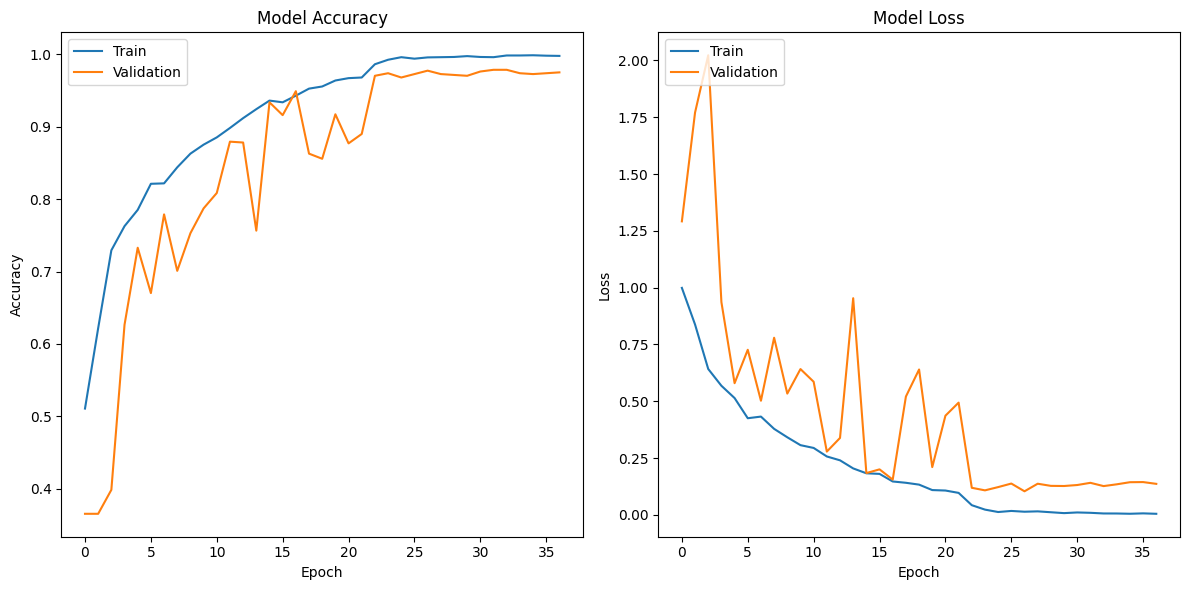

27/27 - 2s - loss: 0.1036 - accuracy: 0.9775 - f1_score: 0.9775 - 2s/epoch - 57ms/step
Test Accuracy: 0.9775413870811462
Test F1 Score: 0.9775413274765015


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.metrics import Metric
from tensorflow.keras.callbacks import EarlyStopping, History, ReduceLROnPlateau
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt

# Set up GPU configuration
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth to avoid memory allocation issues
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is available and configured.")
    except RuntimeError as e:
        print(e)
else:
    print("GPU not available. Using CPU.")

# Custom F1 Score Metric
class F1Score(Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(tf.math.round(y_pred), tf.float32)
        self.true_positives.assign_add(tf.reduce_sum(y_true * y_pred))
        self.false_positives.assign_add(tf.reduce_sum((1 - y_true) * y_pred))
        self.false_negatives.assign_add(tf.reduce_sum(y_true * (1 - y_pred)))

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + K.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + K.epsilon())
        f1 = 2 * precision * recall / (precision + recall + K.epsilon())
        return f1

# Squash Activation Function
def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    scale = K.sqrt(s_squared_norm) / (0.5 + s_squared_norm)
    return scale * x

# Softmax Function
def softmax(x, axis=-1):
    ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
    return ex / K.sum(ex, axis=axis, keepdims=True)

# Capsule Layer
class Capsule(Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3, share_weights=True, activation='squash', **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights
        if activation == 'squash':
            self.activation = squash
        else:
            self.activation = layers.Activation(activation)

    def build(self, input_shape):
        super(Capsule, self).build(input_shape)
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(1, input_dim_capsule, self.num_capsule * self.dim_capsule),
                                     initializer='glorot_uniform',
                                     trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(input_num_capsule, input_dim_capsule, self.num_capsule * self.dim_capsule),
                                     initializer='glorot_uniform',
                                     trainable=True)

    def call(self, u_vecs):
        if self.share_weights:
            u_hat_vecs = K.conv1d(u_vecs, self.W)
        else:
            u_hat_vecs = K.local_conv1d(u_vecs, self.W, [1], [1])

        batch_size = K.shape(u_vecs)[0]
        input_num_capsule = K.shape(u_vecs)[1]
        u_hat_vecs = K.reshape(u_hat_vecs, (batch_size, input_num_capsule, self.num_capsule, self.dim_capsule))
        u_hat_vecs = K.permute_dimensions(u_hat_vecs, (0, 2, 1, 3))
        b = K.zeros_like(u_hat_vecs[:,:,:,0])
        for i in range(self.routings):
            c = softmax(b, 1)
            o = tf.einsum('bin,binj->bij', c, u_hat_vecs)
            if K.backend() == 'theano':
                o = K.sum(o, axis=1)
            if i < self.routings - 1:
                o = K.l2_normalize(o, -1)
                b = tf.einsum('bij,binj->bin', o, u_hat_vecs)
                if K.backend() == 'theano':
                    b = K.sum(b, axis=1)
        return self.activation(o)

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)

# Attention Mechanism
def attention_block(inputs, filters):
    attention = layers.Conv2D(filters, (1, 1), activation='relu', padding='same')(inputs)
    attention = layers.Conv2D(filters, (1, 1), activation='sigmoid', padding='same')(attention)
    return layers.multiply([inputs, attention])

# Residual Block
def residual_block(inputs, filters):
    x = layers.Conv2D(filters, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.add([x, inputs])
    x = layers.ReLU()(x)
    return x

# Define the model architecture
def get_model(inputShape):
    input_image = Input(shape=inputShape)

    # Initial Convolutional Layer
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_image)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    # Residual Blocks with Attention
    for _ in range(2):
        x = residual_block(x, 32)
        x = attention_block(x, 32)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    for _ in range(2):
        x = residual_block(x, 64)
        x = attention_block(x, 64)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    for _ in range(2):
        x = residual_block(x, 128)
        x = attention_block(x, 128)

    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    for _ in range(2):
        x = residual_block(x, 256)
        x = attention_block(x, 256)

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Capsule Layer
    x = layers.Reshape((-1, 256))(x)
    capsule = Capsule(num_capsule=10, dim_capsule=16, routings=3, share_weights=True)(x)
    capsule = layers.Flatten()(capsule)
    capsule = layers.Dense(128, activation='relu')(capsule)
    capsule = layers.Dropout(0.5)(capsule)

    # Output Layer
    output = layers.Dense(3, activation='softmax')(capsule)

    # Create and compile the model
    model = models.Model(inputs=input_image, outputs=output)
    model.compile(loss='categorical_crossentropy',optimizer=RMSprop(), metrics=['accuracy', F1Score()])
    model.summary()

    return model

# Instantiate the model
model = get_model((200, 200, 3))

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# History callback
history = History()

# Train the model
epochs = 80
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=test_generator,
    validation_steps=len(test_generator),
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr]
)

# Plot training & validation accuracy and loss values in a single graph
plt.figure(figsize=(12, 6))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Show the plots
plt.tight_layout()
plt.show()

# Evaluate the model
test_loss, test_acc, test_f1_score = model.evaluate(test_generator, verbose=2)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", test_f1_score)


# Using Adadelta

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.metrics import Metric
from tensorflow.keras.callbacks import EarlyStopping, History, ReduceLROnPlateau
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adadelta
import matplotlib.pyplot as plt

# Set up GPU configuration
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth to avoid memory allocation issues
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is available and configured.")
    except RuntimeError as e:
        print(e)
else:
    print("GPU not available. Using CPU.")

# Custom F1 Score Metric
class F1Score(Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(tf.math.round(y_pred), tf.float32)
        self.true_positives.assign_add(tf.reduce_sum(y_true * y_pred))
        self.false_positives.assign_add(tf.reduce_sum((1 - y_true) * y_pred))
        self.false_negatives.assign_add(tf.reduce_sum(y_true * (1 - y_pred)))

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + K.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + K.epsilon())
        f1 = 2 * precision * recall / (precision + recall + K.epsilon())
        return f1

# Squash Activation Function
def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    scale = K.sqrt(s_squared_norm) / (0.5 + s_squared_norm)
    return scale * x

# Softmax Function
def softmax(x, axis=-1):
    ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
    return ex / K.sum(ex, axis=axis, keepdims=True)

# Capsule Layer
class Capsule(Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3, share_weights=True, activation='squash', **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights
        if activation == 'squash':
            self.activation = squash
        else:
            self.activation = layers.Activation(activation)

    def build(self, input_shape):
        super(Capsule, self).build(input_shape)
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(1, input_dim_capsule, self.num_capsule * self.dim_capsule),
                                     initializer='glorot_uniform',
                                     trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(input_num_capsule, input_dim_capsule, self.num_capsule * self.dim_capsule),
                                     initializer='glorot_uniform',
                                     trainable=True)

    def call(self, u_vecs):
        if self.share_weights:
            u_hat_vecs = K.conv1d(u_vecs, self.W)
        else:
            u_hat_vecs = K.local_conv1d(u_vecs, self.W, [1], [1])

        batch_size = K.shape(u_vecs)[0]
        input_num_capsule = K.shape(u_vecs)[1]
        u_hat_vecs = K.reshape(u_hat_vecs, (batch_size, input_num_capsule, self.num_capsule, self.dim_capsule))
        u_hat_vecs = K.permute_dimensions(u_hat_vecs, (0, 2, 1, 3))
        b = K.zeros_like(u_hat_vecs[:,:,:,0])
        for i in range(self.routings):
            c = softmax(b, 1)
            o = tf.einsum('bin,binj->bij', c, u_hat_vecs)
            if K.backend() == 'theano':
                o = K.sum(o, axis=1)
            if i < self.routings - 1:
                o = K.l2_normalize(o, -1)
                b = tf.einsum('bij,binj->bin', o, u_hat_vecs)
                if K.backend() == 'theano':
                    b = K.sum(b, axis=1)
        return self.activation(o)

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)

# Attention Mechanism
def attention_block(inputs, filters):
    attention = layers.Conv2D(filters, (1, 1), activation='relu', padding='same')(inputs)
    attention = layers.Conv2D(filters, (1, 1), activation='sigmoid', padding='same')(attention)
    return layers.multiply([inputs, attention])

# Residual Block
def residual_block(inputs, filters):
    x = layers.Conv2D(filters, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.add([x, inputs])
    x = layers.ReLU()(x)
    return x

# Define the model architecture
def get_model(inputShape):
    input_image = Input(shape=inputShape)

    # Initial Convolutional Layer
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_image)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    # Residual Blocks with Attention
    for _ in range(2):
        x = residual_block(x, 32)
        x = attention_block(x, 32)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    for _ in range(2):
        x = residual_block(x, 64)
        x = attention_block(x, 64)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    for _ in range(2):
        x = residual_block(x, 128)
        x = attention_block(x, 128)

    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    for _ in range(2):
        x = residual_block(x, 256)
        x = attention_block(x, 256)

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Capsule Layer
    x = layers.Reshape((-1, 256))(x)
    capsule = Capsule(num_capsule=10, dim_capsule=16, routings=3, share_weights=True)(x)
    capsule = layers.Flatten()(capsule)
    capsule = layers.Dense(128, activation='relu')(capsule)
    capsule = layers.Dropout(0.5)(capsule)

    # Output Layer
    output = layers.Dense(3, activation='softmax')(capsule)

    # Create and compile the model
    model = models.Model(inputs=input_image, outputs=output)
    model.compile(loss='categorical_crossentropy',optimizer=Adadelta(), metrics=['accuracy', F1Score()])
    model.summary()

    return model

# Instantiate the model
model = get_model((200, 200, 3))

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# History callback
history = History()

# Train the model
epochs = 80
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=test_generator,
    validation_steps=len(test_generator),
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr]
)

# Plot training & validation accuracy and loss values in a single graph
plt.figure(figsize=(12, 6))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Show the plots
plt.tight_layout()
plt.show()

# Evaluate the model
test_loss, test_acc, test_f1_score = model.evaluate(test_generator, verbose=2)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", test_f1_score)
